# **Team 16 - EDSA movie recommendation wilderness**

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://storage.googleapis.com/kaggle-competitions/kaggle/33594/logos/header.png?t=2022-01-04-10-31-44")

<a id="cont"></a>

### Table of Contents

<a href=#one>1. Problem Statement</a>

<a href=#one>2. Importing Libraries</a>

<a href=#two>3. Loading Data</a>

<a href=#three>4. Data Preprocessing</a>

<a href=#four>5. Exploratory Data Analysis</a>

<a href=#five>6. Content Based Filtering</a>

<a href=#six>7. Collaborative Filtering</a>

<a href=#six>8. Model Evaluation</a>

<a href=#seven>9. Hyperparameter Tuning</a>

<a href=#seven>10. Conclusion</a>

<a href=#seven>11. Submission</a>

### 1. Problem Statement

Construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences. To achieve this, we will contruct a recommendation system.

Recommendation Systems we will be exploring:

 - Collaborative Based Filtering
 - Content Based Filtering

<a id="one"></a>
### 2. Importing Libraries

In [2]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Kaggle requirements
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data analysis libraries
import pandas as pd
import numpy as np        
        
# ML Pre processing
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState

# Visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
sns.set()

# Content Filtering Models
from sklearn.neighbors import NearestNeighbors

# Suprise
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split

# Collaborative Filtering
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

# Evaluation
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise.accuracy import rmse
from surprise import accuracy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Hyperparameter tuning
from surprise.model_selection import GridSearchCV

/kaggle/input/edsa-movie-recommendation-wilderness/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-wilderness/movies.csv
/kaggle/input/edsa-movie-recommendation-wilderness/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-wilderness/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-wilderness/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-wilderness/train.csv
/kaggle/input/edsa-movie-recommendation-wilderness/test.csv
/kaggle/input/edsa-movie-recommendation-wilderness/tags.csv
/kaggle/input/edsa-movie-recommendation-wilderness/links.csv


<a id="two"></a>
### 3. Loading Data

In [3]:
movies = pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/movies.csv")
imdb_data = pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/imdb_data.csv")
genome_tags = pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/genome_tags.csv")
genome_scores = pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/genome_scores.csv")
tags = pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/tags.csv")
links = pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/links.csv")
train_data = pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/train.csv")
test_data = pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/test.csv")

<a id="three"></a>
### 4. Data Preprocessing

**Data preview**

In [ ]:
movies.head(3)

In [ ]:
imdb_data.head(3)

In [ ]:
genome_tags.head(3)

In [ ]:
genome_scores.head(3)

In [ ]:
tags.head(3)

In [ ]:
links.head(3)

In [ ]:
train_data.head(3)

In [4]:
# check duplicates
dup_bool = train_data.duplicated(['userId', 'movieId', 'rating', 'timestamp'])

# display duplicates
print("Number of duplicate records:", sum(dup_bool))

Number of duplicate records: 0


In [5]:
# fill NaN values with usable nulls

imdb_data['director'] = imdb_data['director'].fillna('')
imdb_data['runtime'] = imdb_data['runtime'].fillna('')
imdb_data['budget'] = imdb_data['budget'].fillna('')
imdb_data['title_cast'] = imdb_data['title_cast'].fillna('')
imdb_data['plot_keywords'] = imdb_data['plot_keywords'].fillna('')

In [6]:
# remove string seperators and add to a list

imdb_data['plot_keywords'] = imdb_data['plot_keywords'].str.split('|')
imdb_data['title_cast'] = imdb_data['title_cast'].str.split('|')
movies['genres'] = movies['genres'].str.split('|')

In [7]:
# extract year from title into own feature

movies['year'] = movies['title'].str.extract('(\d{4})')

In [8]:
def year_remover(text):
    
    """Function that takes in a string, and removes the year in parenthesis"""
    
    text = re.sub(r'\([^)]*\)','',text)
    return text

movies['title'] = movies['title'].map(year_remover)

In [9]:
movies.head(3)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995


<a id="four"></a>
### 5. Exploratory Data Analysis

> ### Genres

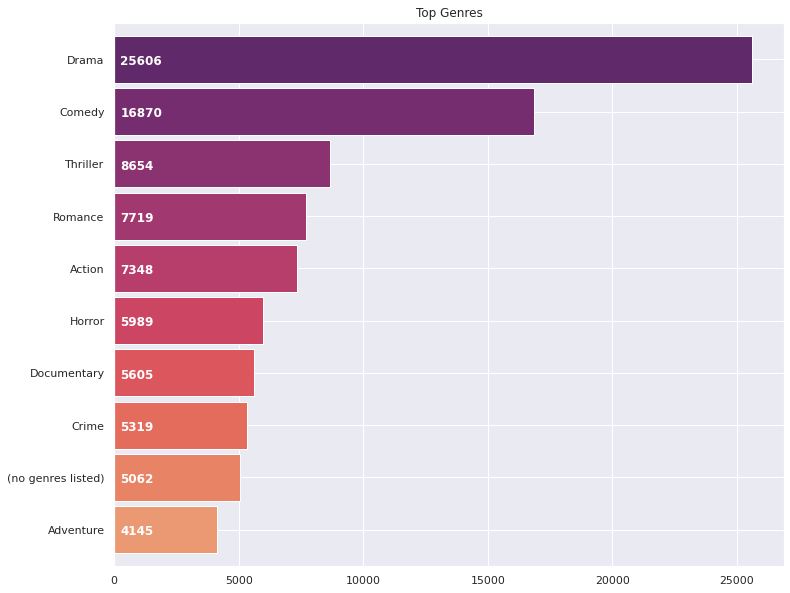

In [10]:
# Plot Distribution of Genres

plt.subplots(figsize=(12,10))
list1 = []
sns.set(style='whitegrid', palette='flare',
        rc={'figure.figsize': (15,10)})

for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('flare',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(250, i-.10, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

> ### Actors

In [ ]:
# Plot Distribution of Actors

plt.subplots(figsize=(12,10))
list1=[]
for i in imdb_data['title_cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[1:11].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('flare',10))
for i, v in enumerate(pd.Series(list1).value_counts()[1:11].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

> ### Directors

In [ ]:
# Plot Distribution of Directors

def xstr(s):
    if s is None:
        return ''
    return str(s)
imdb_data['director'] = imdb_data['director'].apply(xstr)
plt.subplots(figsize=(12,10))
ax = imdb_data[imdb_data['director']!=''].director.value_counts()[2:12].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('flare',10))
for i, v in enumerate(imdb_data[imdb_data['director']!=''].director.value_counts()[2:12].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

> ### Plot keywords

In [ ]:
# Create wordcloud of plot_keywords

cloud = ''
for i in imdb_data['plot_keywords']:
    for e in i:
        cloud += ' '+ str(e)

> ### Ratings

In [ ]:
print (f'Number of ratings in dataset: {train_data.shape[0]}')

In [ ]:
# Plot Distribution of Ratings

with sns.axes_style('white'):
    g = sns.factorplot('rating', data=train_data, aspect=2.0,kind='count')
    g.set_ylabels('Total number of ratings')
print (f'Average rating in dataset: {np.mean(train_data["rating"])}')

**Joining dataFrames**

The data was provided in multiple csv files, the analysis of the data will be simpler and more efficiently carried out if the multiple files are joined to form one dataframe.

In [11]:
joint_df = train_data.merge(movies,on='movieId').merge(imdb_data,on='movieId')
joint_df.head(3)

,userId,movieId,rating,timestamp,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
1,87388,57669,3.5,1237455297,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"
2,137050,57669,4.0,1425631854,In Bruges,"[Comedy, Crime, Drama, Thriller]",2008,"[Elizabeth Berrington, Rudy Blomme, Olivier Bo...",Martin McDonagh,107.0,"$15,000,000","[dwarf, bruges, irish, hitman]"


In [16]:
joint_df['genres'] = [','.join(map(str, l)) for l in joint_df['genres']]
joint_df['title_cast'] = [','.join(map(str, l)) for l in joint_df['title_cast']]
joint_df['plot_keywords'] = [','.join(map(str, l)) for l in joint_df['plot_keywords']]
joint_df.head()

,userId,movieId,rating,timestamp,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges,"Comedy,Crime,Drama,Thriller",2008,"Elizabeth Berrington,Rudy Blomme,Olivier Bonjo...",Martin McDonagh,107.0,"$15,000,000","dwarf,bruges,irish,hitman"
1,87388,57669,3.5,1237455297,In Bruges,"Comedy,Crime,Drama,Thriller",2008,"Elizabeth Berrington,Rudy Blomme,Olivier Bonjo...",Martin McDonagh,107.0,"$15,000,000","dwarf,bruges,irish,hitman"
2,137050,57669,4.0,1425631854,In Bruges,"Comedy,Crime,Drama,Thriller",2008,"Elizabeth Berrington,Rudy Blomme,Olivier Bonjo...",Martin McDonagh,107.0,"$15,000,000","dwarf,bruges,irish,hitman"
3,120490,57669,4.5,1408228517,In Bruges,"Comedy,Crime,Drama,Thriller",2008,"Elizabeth Berrington,Rudy Blomme,Olivier Bonjo...",Martin McDonagh,107.0,"$15,000,000","dwarf,bruges,irish,hitman"
4,50616,57669,4.5,1446941640,In Bruges,"Comedy,Crime,Drama,Thriller",2008,"Elizabeth Berrington,Rudy Blomme,Olivier Bonjo...",Martin McDonagh,107.0,"$15,000,000","dwarf,bruges,irish,hitman"


In [18]:
# replace each plot_keywords observation, with only the first 4 words in the plot_keywords column
joint_df['plot_keywords'] = joint_df['plot_keywords'].str.extract('(^\w+\W\w+\W\w+\W\w+)')
# Then replace NaN values again with nulls a computer understands
joint_df['plot_keywords'] = joint_df['plot_keywords'].fillna('')

In [19]:
# replace each cast observation, with only the first 2 cast members
joint_df['title_cast'] = joint_df['title_cast'].str.extract('(^\w+\W\w+\W\w+\W\w+)')
# Then replace NaN values again with nulls a computer understands
joint_df['title_cast'] = joint_df['title_cast'].fillna('')

In [20]:
joint_df.head(3)

,userId,movieId,rating,timestamp,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges,"Comedy,Crime,Drama,Thriller",2008,"Elizabeth Berrington,Rudy Blomme",Martin McDonagh,107.0,"$15,000,000","dwarf,bruges,irish,hitman"
1,87388,57669,3.5,1237455297,In Bruges,"Comedy,Crime,Drama,Thriller",2008,"Elizabeth Berrington,Rudy Blomme",Martin McDonagh,107.0,"$15,000,000","dwarf,bruges,irish,hitman"
2,137050,57669,4.0,1425631854,In Bruges,"Comedy,Crime,Drama,Thriller",2008,"Elizabeth Berrington,Rudy Blomme",Martin McDonagh,107.0,"$15,000,000","dwarf,bruges,irish,hitman"


In [21]:
# Concatenate columns into single column for vectorization
joint_df['combined'] = joint_df['title'] + ',' + joint_df['genres'] + ',' + joint_df['title_cast'] + ',' + joint_df['director'] + ',' + joint_df['plot_keywords']

### 6. Content Based Filtering (with dimensionality Reduction)
The content-based approach uses additional information about users and/or items. This filtering method uses item features to recommend other items similar to what the user likes and also based on their previous actions or explicit feedback.

- Principal Component Analysis (PCA)
-
-

In [22]:
# Vectorizer for numerical representation
vect = CountVectorizer()

### 7. Collaborative Filtering
The Collaborative filtering method for recommender systems is a method that is solely based on the past interactions that have been recorded between users and items, in order to produce new recommendations. In essence, Collaborative Filtering looks at similarities between users.
- Matrix Factorization-based algorithms
    - Singular Value Decomposition (SVD)
    - Non-negative matrix factorization (NMF)
    - Slope One
    - Co-clustering
- k-Nearest Neighbors (KNN)
    - KNNWithMeans
    - KNNWithZScore
   
#### Data Used in Collaborative Filtering:
 - train data (for model training and evaluation)
 - test data (for submission)

In [49]:
# Loading as Surprise dataframe
df_train = train_data.copy()

# Select sample size of 500 000 to test base models
#sample_df = df_train.sample(n=10000)

reader = Reader(rating_scale=(0.5, 5)) #reader = Reader()
# Data selected for model training
data = Dataset.load_from_df(df_train[["userId", "movieId", "rating"]], reader)

In [50]:
trainset, testset = train_test_split(data, test_size=0.01)

#### Singular Value Decomposition (SVD)

In [51]:
#Takes long to run
svd = SVD()
svd.fit(trainset)

In [52]:
svd_pred = svd.test(testset) 

In [53]:
svd_rmse = rmse(svd_pred)

RMSE: 0.8187


#### Non-negative matrix factorization (NMF)

In [ ]:
nmf = NMF()
nmf.fit(trainset)

In [ ]:
nmf_pred = nmf.test(testset)

In [ ]:
nmf_rmse = rmse(nmf_pred)

#### Slope One

In [ ]:
slope = SlopeOne()
slope.fit(trainset)

In [ ]:
slope_pred = slope.test(testset)

In [ ]:
slope_rmse = rmse(slope_pred)

#### Co-clustering

In [ ]:
cc = CoClustering()
cc.fit(trainset)

In [ ]:
cc_pred = cc.test(testset)

In [ ]:
cc_rmse = rmse(cc_pred)

#### KNNWithMeans

In [ ]:
knnm = KNNWithMeans()
knnm.fit(trainset)

In [ ]:
knnm_pred = knnm.test(testset) 

In [ ]:
knnm_rmse = rmse(knnm_pred)

#### KNNWithZScore

In [ ]:
knnz = KNNWithZScore()
knnz.fit(trainset)

In [ ]:
knnz_pred = knnz.test(testset) 

In [ ]:
knnz_rmse = rmse(knnz_pred)

### 8. Evaluating Model Performances
 - Select best model for Hyperparameter Tuning and Submission

In [ ]:
# Compare Weighted RMSE Between Models

fig,axis = plt.subplots(figsize=(11, 2))
rmse_y = ['SVD','NMF','Slope One', 'Co-Clustering', 'KNNWithMeans', 'KNNWithZScore']
rmse_x = [svd_rmse,nmf_rmse,slope_rmse, cc_rmse, knnm_rmse, knnz_rmse]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Model RMSE Compared',fontsize=13)
plt.xlabel('RMSE', size=13)
plt.yticks(size=12)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(i.get_x() + i.get_height()*1.5, i.get_y() + i.get_height()-0.2, round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
    
plt.show()

### 9. Hyperparameter Tuning
 - Hyperparameter Tuning of Best performing Model
 - In collaboration with Comet

### 10. Conculsion

### 11. Submission

In [ ]:
#takes long to run
ratings_predictions=[svd.predict(row.userId, row.movieId) for _,row in test_data.iterrows()]

In [44]:
df_pred=pd.DataFrame(ratings_predictions)
df_pred
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [45]:
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [46]:
df_pred.head()

,userId,movieId,rating,Id
0,1,2011,3.852964,1_2011
1,1,4144,3.837873,1_4144
2,1,5767,3.636884,1_5767
3,1,6711,4.113102,1_6711
4,1,7318,3.080197,1_7318


In [47]:
df_pred.drop(['userId', 'movieId'], inplace=True, axis= 1)
df_pred = df_pred[['Id', 'rating']]

In [48]:
df_pred.to_csv("trial3.csv", index=False)